In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import math
import os
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from loanapprovalprediction.constants import (
    CATEGORICAL_VARIABLES,
    CONTINUOUS_VARIABLES,
    TARGET,
)

sns.set_theme()

DATA_DIR = Path(os.getcwd()).parent / "data"

## First time setup
Download and unzip the data to the data directory.

In [16]:
!kaggle competitions download -c playground-series-s4e10 -p ../data

... resuming from 0 bytes (1515882 bytes left) ...
 69%|██████████████████████████▎           | 1.00M/1.45M [00:00<00:00, 3.01MB/s]
100%|██████████████████████████████████████| 1.45M/1.45M [00:00<00:00, 3.93MB/s]


In [30]:
with zipfile.ZipFile(DATA_DIR / "playground-series-s4e10.zip", 'r') as zipped:
    zipped.extractall(DATA_DIR)
os.listdir(DATA_DIR)

['train.csv',
 'sample_submission.csv',
 'test.csv',
 'playground-series-s4e10.zip']

## Exploratory Data analysis

In [3]:
train = pl.read_csv(DATA_DIR / "train.csv")
test = pl.read_csv(DATA_DIR / "test.csv")
train

id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
i64,i64,i64,str,f64,str,str,i64,f64,f64,str,i64,i64
0,37,35000,"""RENT""",0.0,"""EDUCATION""","""B""",6000,11.49,0.17,"""N""",14,0
1,22,56000,"""OWN""",6.0,"""MEDICAL""","""C""",4000,13.35,0.07,"""N""",2,0
2,29,28800,"""OWN""",8.0,"""PERSONAL""","""A""",6000,8.9,0.21,"""N""",10,0
3,30,70000,"""RENT""",14.0,"""VENTURE""","""B""",12000,11.11,0.17,"""N""",5,0
4,22,60000,"""RENT""",2.0,"""MEDICAL""","""A""",6000,6.92,0.1,"""N""",3,0
…,…,…,…,…,…,…,…,…,…,…,…,…
58640,34,120000,"""MORTGAGE""",5.0,"""EDUCATION""","""D""",25000,15.95,0.21,"""Y""",10,0
58641,28,28800,"""RENT""",0.0,"""MEDICAL""","""C""",10000,12.73,0.35,"""N""",8,1
58642,23,44000,"""RENT""",7.0,"""EDUCATION""","""D""",6800,16.0,0.15,"""N""",2,1


In [42]:
train.select(CONTINUOUS_VARIABLES).describe()

statistic,person_age,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
str,f64,f64,f64,f64,f64,f64
"""count""",58645.0,58645.0,58645.0,58645.0,58645.0,58645.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",27.550857,64046.172871,9217.556518,10.677874,0.159238,5.813556
"""std""",6.033216,37931.106978,5563.807384,3.034697,0.091692,4.029196
"""min""",20.0,4200.0,500.0,5.42,0.0,2.0
"""25%""",23.0,42000.0,5000.0,7.88,0.09,3.0
"""50%""",26.0,58000.0,8000.0,10.75,0.14,4.0
"""75%""",30.0,75600.0,12000.0,12.99,0.21,8.0
"""max""",123.0,1.9e6,35000.0,23.22,0.83,30.0


## Notes on descriptives:
- There are no null datapoints
- Some of the ranges are relatively large due to some very high maxes (e.g., `age` max is 123,  `person_income` max is 1.9e6)

In [7]:
train.select(TARGET).mean()

loan_status
f64
0.142382


In [11]:
train.with_columns(pl.lit("train").alias("type")).drop()
test.with_columns(pl.lit("test").alias("type"))

id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,type
i64,i64,i64,str,f64,str,str,i64,f64,f64,str,i64,str
58645,23,69000,"""RENT""",3.0,"""HOMEIMPROVEMENT""","""F""",25000,15.76,0.36,"""N""",2,"""test"""
58646,26,96000,"""MORTGAGE""",6.0,"""PERSONAL""","""C""",10000,12.68,0.1,"""Y""",4,"""test"""
58647,26,30000,"""RENT""",5.0,"""VENTURE""","""E""",4000,17.19,0.13,"""Y""",2,"""test"""
58648,33,50000,"""RENT""",4.0,"""DEBTCONSOLIDATION""","""A""",7000,8.9,0.14,"""N""",7,"""test"""
58649,26,102000,"""MORTGAGE""",8.0,"""HOMEIMPROVEMENT""","""D""",15000,16.32,0.15,"""Y""",4,"""test"""
…,…,…,…,…,…,…,…,…,…,…,…,…
97738,22,31200,"""MORTGAGE""",2.0,"""DEBTCONSOLIDATION""","""B""",3000,10.37,0.1,"""N""",4,"""test"""
97739,22,48000,"""MORTGAGE""",6.0,"""EDUCATION""","""A""",7000,6.03,0.15,"""N""",3,"""test"""
97740,51,60000,"""MORTGAGE""",0.0,"""PERSONAL""","""A""",15000,7.51,0.25,"""N""",25,"""test"""


In [12]:
combined = pl.concat([
    train.with_columns(pl.lit("train").alias("type")).drop(TARGET), 
    test.with_columns(pl.lit("test").alias("type"))
])

combined

id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,type
i64,i64,i64,str,f64,str,str,i64,f64,f64,str,i64,str
0,37,35000,"""RENT""",0.0,"""EDUCATION""","""B""",6000,11.49,0.17,"""N""",14,"""train"""
1,22,56000,"""OWN""",6.0,"""MEDICAL""","""C""",4000,13.35,0.07,"""N""",2,"""train"""
2,29,28800,"""OWN""",8.0,"""PERSONAL""","""A""",6000,8.9,0.21,"""N""",10,"""train"""
3,30,70000,"""RENT""",14.0,"""VENTURE""","""B""",12000,11.11,0.17,"""N""",5,"""train"""
4,22,60000,"""RENT""",2.0,"""MEDICAL""","""A""",6000,6.92,0.1,"""N""",3,"""train"""
…,…,…,…,…,…,…,…,…,…,…,…,…
97738,22,31200,"""MORTGAGE""",2.0,"""DEBTCONSOLIDATION""","""B""",3000,10.37,0.1,"""N""",4,"""test"""
97739,22,48000,"""MORTGAGE""",6.0,"""EDUCATION""","""A""",7000,6.03,0.15,"""N""",3,"""test"""
97740,51,60000,"""MORTGAGE""",0.0,"""PERSONAL""","""A""",15000,7.51,0.25,"""N""",25,"""test"""


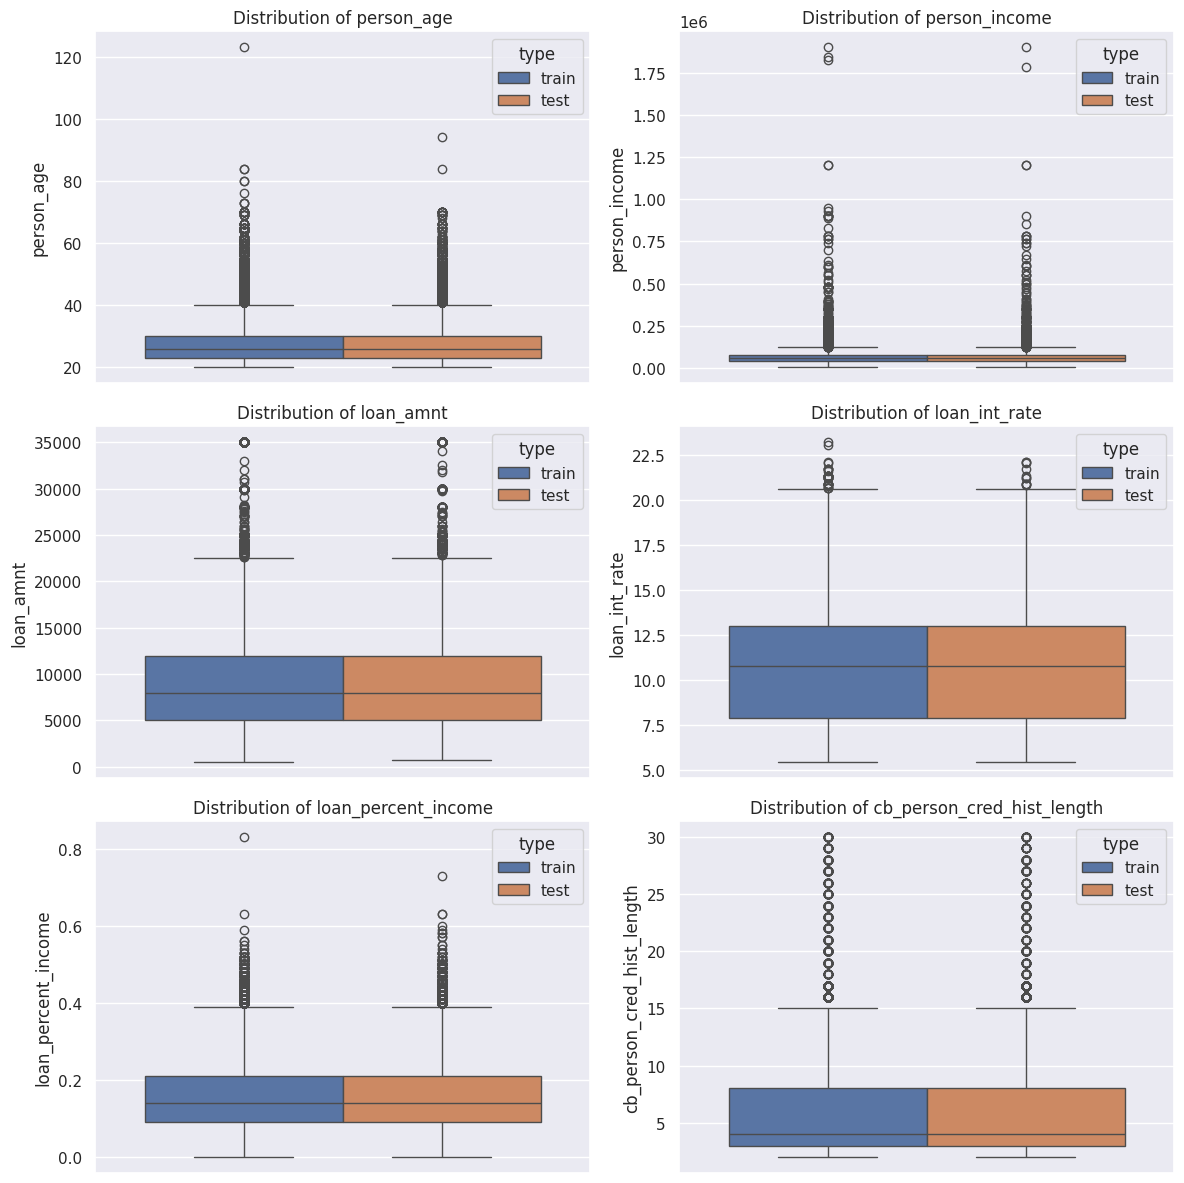

In [13]:
n_cols = 2
n_rows = math.ceil(len(CONTINUOUS_VARIABLES) / n_cols)
    
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes_flat = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

for idx, (ax, var) in enumerate(zip(axes_flat, CONTINUOUS_VARIABLES)):
    sns.boxplot(data=combined, hue="type", y=var, ax=ax)
    ax.set_title(f'Distribution of {var}')

for idx in range(len(CONTINUOUS_VARIABLES), len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()

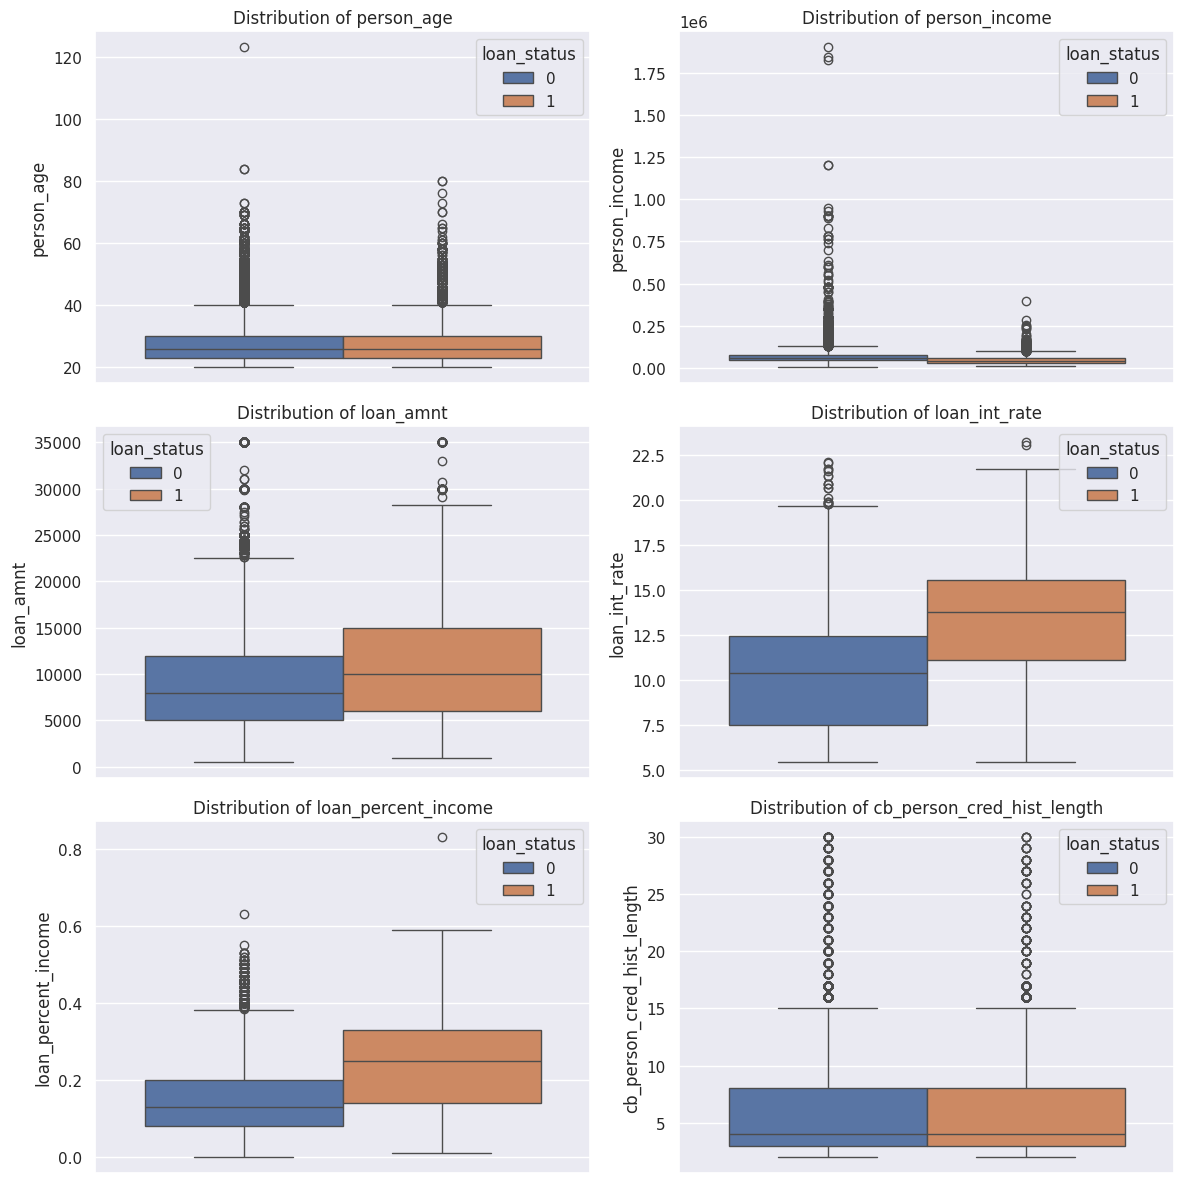

In [73]:
n_cols = 2
n_rows = math.ceil(len(CONTINUOUS_VARIABLES) / n_cols)
    
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes_flat = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

for idx, (ax, var) in enumerate(zip(axes_flat, CONTINUOUS_VARIABLES)):
    sns.boxplot(data=train, hue=TARGET, y=var, ax=ax)
    ax.set_title(f'Distribution of {var}')

for idx in range(len(CONTINUOUS_VARIABLES), len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()

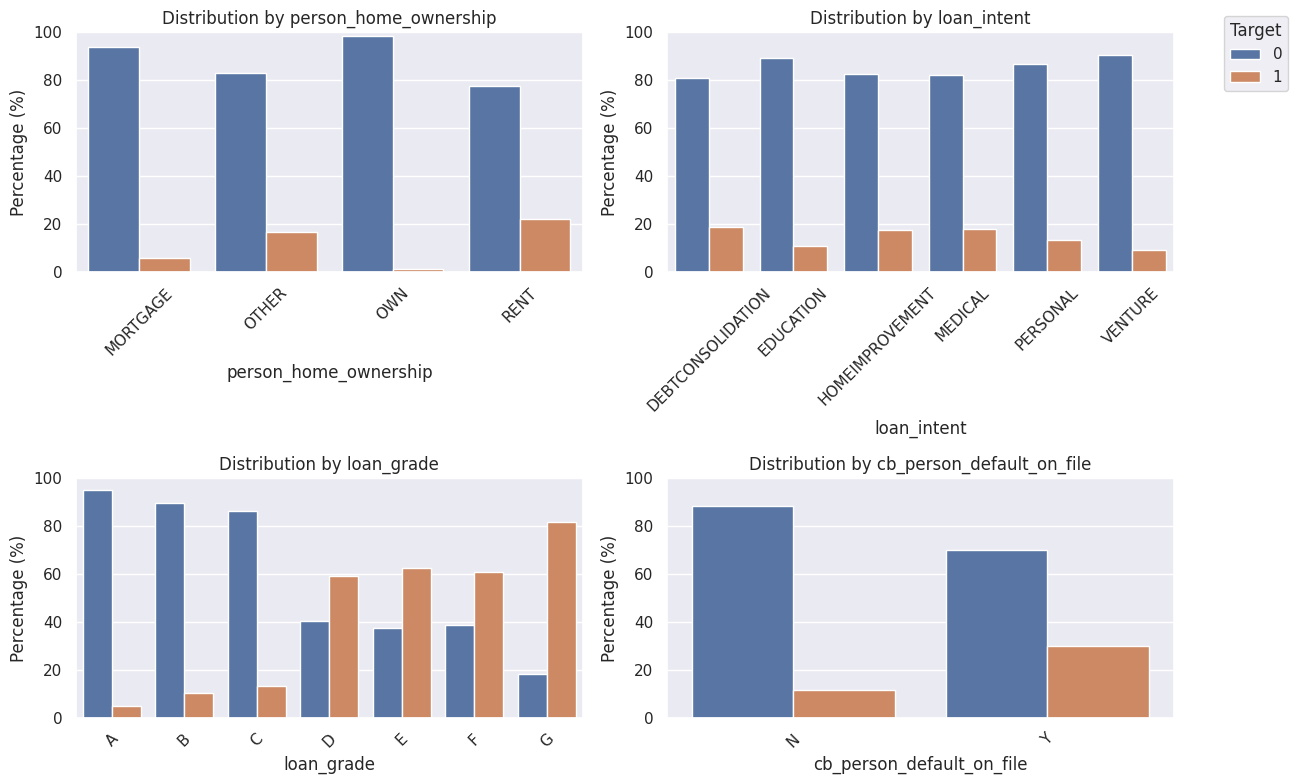

In [121]:
def create_barplot_grid(data, target, variables, n_cols=2):
    n_rows = math.ceil(len(variables) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    axes_flat = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]   
    legend_handles, legend_labels = None, None
    
    for idx, (ax, var) in enumerate(zip(axes_flat, variables)):
        proportions = (data.to_pandas()
                      .groupby(var)[target]
                      .value_counts(normalize=True)
                      .mul(100)
                      .reset_index(name='proportion')
                      .rename(columns={target: 'Target'}))
        
        sns.barplot(
            data=proportions,
            x=var,
            y='proportion',
            hue='Target',
            ax=ax
        )
        
        if idx == 0:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        
        ax.set_title(f'Distribution by {var}')
        ax.set_ylabel('Percentage (%)')
        
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 100)
            
    # Remove empty subplots
    for idx in range(len(variables), len(axes_flat)):
        fig.delaxes(axes_flat[idx])
    
    fig.legend(legend_handles, legend_labels, 
              bbox_to_anchor=(1.02, 0.98),
              loc='upper left',
              title='Target')
    
    plt.tight_layout()
    return fig

fig = create_barplot_grid(
    data=train,
    target=TARGET,
    variables=CATEGORICAL_VARIABLES,
    n_cols=2
)